In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [4]:
!nvidia-smi

Sun Feb 28 14:17:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Dataset/dataset_new'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=100)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
print(dataset_sizes)

{'train': 15501, 'val': 1934, 'test': 1944}


In [8]:
class_names

['aloo baigan images',
 'aloo gobi images',
 'aloo paratha images',
 'aloo pat gobi images',
 'athirasam images',
 'bhel puri images',
 'bread images',
 'butter masala paneer images',
 'capati images',
 'chana shag images',
 'channa dal masala images',
 'chicken beryani images',
 'chicken makhani images',
 'chole (curried chickpeas) images',
 'dhokla images',
 'dosai images',
 'indian mattar paneer images',
 'indian paneer tikka images',
 'indian tandoori wrap images',
 'indian thalipith images',
 'khichdi images',
 'koftay images',
 'lamb madras curry images',
 'lapsi (sweet bulgur) images',
 'mughlai paratha images',
 'onion pakoda images',
 'orange lentils images',
 'palak paneer images',
 'papadom images',
 'puliyogre images',
 'punjabi curry with pakora images',
 'rajmah images',
 'samosa - meat and veg images',
 'shev dahi batata puri images',
 'shimla mirch aloo images',
 'spicy indian rice images',
 'string hoppers (idiyapam) images',
 'tomato chicken images',
 'uttapam images'

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.simplefilter("ignore")

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))            
            
            torch.save(model.state_dict(), '/content/food308_efnetb2.pth')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

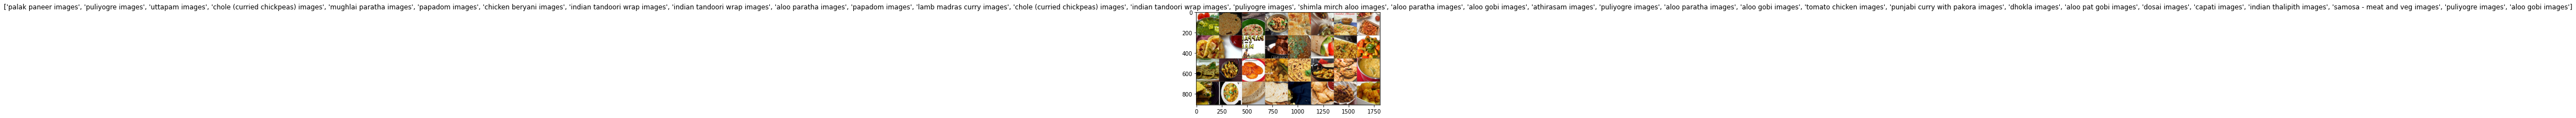

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
pwd

'/content'

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} || actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 40)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

Loaded pretrained weights for efficientnet-b2


In [14]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 2.1538 Acc: 0.4453
Training complete in 8m 57s
val Loss: 1.0099 Acc: 0.7187
Training complete in 10m 8s
test Loss: 0.9937 Acc: 0.7289
Training complete in 11m 16s

Epoch 2/10
----------
train Loss: 1.1154 Acc: 0.6810
Training complete in 8m 46s
val Loss: 0.6727 Acc: 0.8056
Training complete in 9m 58s
test Loss: 0.6591 Acc: 0.8117
Training complete in 11m 8s

Epoch 3/10
----------
train Loss: 0.8778 Acc: 0.7461
Training complete in 8m 47s
val Loss: 0.5019 Acc: 0.8583
Training complete in 9m 59s
test Loss: 0.4665 Acc: 0.8657
Training complete in 11m 8s

Epoch 4/10
----------
train Loss: 0.7354 Acc: 0.7847
Training complete in 8m 43s
val Loss: 0.4099 Acc: 0.8878
Training complete in 9m 55s
test Loss: 0.3839 Acc: 0.8915
Training complete in 11m 3s

Epoch 5/10
----------
train Loss: 0.6108 Acc: 0.8223
Training complete in 8m 47s
val Loss: 0.3512 Acc: 0.9095
Training complete in 9m 58s
test Loss: 0.3161 Acc: 0.9198
Training complete in 11m 7s

Epoch 6/10
---

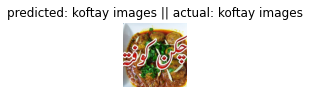

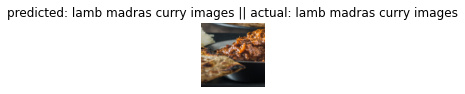

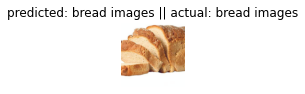

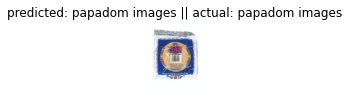

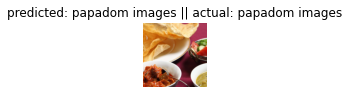

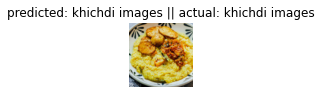

In [15]:
visualize_model(model)

In [20]:
path='/content/weights.pth'
torch.save(model.state_dict(), path)